In [1]:
import pandas as pd
import prototype as pt
from transformers import AutoTokenizer, AutoModel
import torch

c:\users\kobyl\anaconda3\envs\anomaly\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


[]


In [4]:
path_to_data = 'D:\\ubuntu\\zephyr_data\\'

In [19]:
import hashlib

def saveSnippetIntoFile(snippet):
    m = hashlib.sha256()
    m.update(snippet.encode('utf-8'))
    snippet_filename = m.hexdigest() + '.py'
    path_to_file = 'buggy_snippets_files\\' + snippet_filename
    
    with open(path_to_data + path_to_file, 'w', encoding='utf-8') as f:
        f.write(snippet)
        f.close()
    return path_to_file

# Вычисление A-индекса

Вычислим А-индекс.

In [20]:
import pickle5 as pickle

pickle_in = open(path_to_data + 'filtered_traceback_bugfixes.pickle','rb')
data = pickle.load(pickle_in)
data = data[:10000]

In [21]:
data['path_to_file'] = data['before_merge'].apply(saveSnippetIntoFile)
anomaly_results = pd.DataFrame.from_records([(item[3], item[0][22:], item[4])
                                            for item in pt.calc_anomalies(pt.get_python_paths(path_to_data + 'buggy_snippets_files\\'))], 
                                            columns =['a-index', 'path_to_file', 'message'])
df = data.join(anomaly_results.set_index('path_to_file'), on='path_to_file')

# Анализ связи А-индекса с частотой часто встречающихся токенов

In [22]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [23]:
from collections import Counter

df['max_token_occurence'] = df['before_merge'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x.most_common(1)[0][1])
df['max_G_token_occurence'] = df['before_merge'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x['Ġ'])

Token indices sequence length is longer than the specified maximum sequence length for this model (1484 > 512). Running this sequence through the model will result in indexing errors


Видно, что частоты часто встречающихся токенов достаточно сильно коррелированы с А-индексом.

In [24]:
df[['a-index', 'max_token_occurence', 'max_G_token_occurence']].corr(method='spearman')

,a-index,max_token_occurence,max_G_token_occurence
a-index,1.000000,-0.502413,-0.509712
max_token_occurence,-0.502413,1.000000,0.994518
max_G_token_occurence,-0.509712,0.994518,1.000000


Построим диаграмму рассеяния.

In [25]:
import seaborn as sb
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='max_G_token_occurence', ylabel='a-index'>

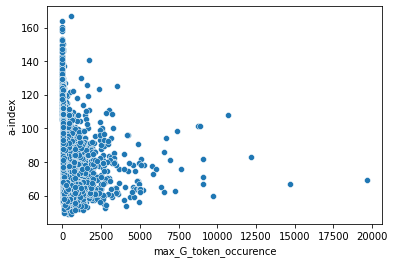

In [26]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df)

Уберем выбросы и снова построим

<AxesSubplot:xlabel='max_G_token_occurence', ylabel='a-index'>

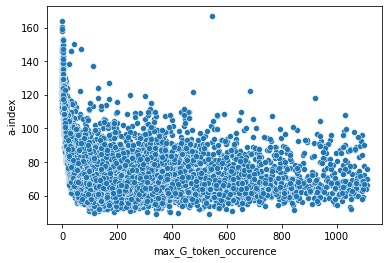

In [27]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_G_token_occurence'] <= df['max_G_token_occurence'].quantile(q=0.95)])

# Анализ связи А-индекса с частотой подряд идущих токенов

Напишем функции для вычисления наибольших частот подряд идущих токенов.

In [28]:
from itertools import groupby

def computeMaxRepetitiveTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    return sorted(token_occurences, key=lambda x: x[1])[-1][1]

In [29]:
def computeMaxRepetitiveGTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    
    max_count = 0
    for token, count in sorted(token_occurences, key=lambda x: x[1]):
        if token == 'Ġ':
            max_count = max(max_count, count)    
    return max_count

Вычислим эти частоты.

In [30]:
df['max_consequtive_token_occurence'] = df['before_merge'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveTokenSequenceLength)
df['max_consequtive_G_token_occurence'] = df['before_merge'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveGTokenSequenceLength)

Подсчитаем корреляции.

In [31]:
df[['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,-0.496758,-0.497377
max_consequtive_token_occurence,-0.496758,1.000000,0.999576
max_consequtive_G_token_occurence,-0.497377,0.999576,1.000000


Посмотрим на графики

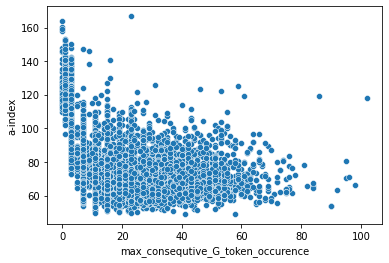

In [32]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df);

Посмотрим на связь с А-индексом при частоте символа G больше 20:

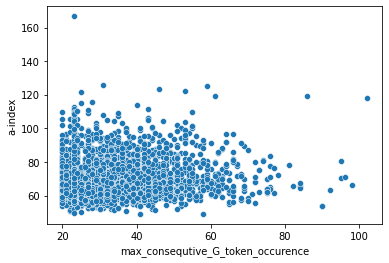

In [33]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_consequtive_G_token_occurence'] >= 20]);

Подсчитаем также корреляции по этой подвыборке

In [34]:
df.loc[df['max_consequtive_G_token_occurence'] >= 20][['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,0.039893,0.039893
max_consequtive_token_occurence,0.039893,1.000000,1.000000
max_consequtive_G_token_occurence,0.039893,1.000000,1.000000


Оценим какова длина этой подвыборки

In [35]:
df.loc[df['max_consequtive_G_token_occurence'] >= 20].shape[0] / 10000 * 100

29.53

Посмотрим на связь А-индекса с частотой для малых значений наибольшей частоты подряд идущих символов:

<AxesSubplot:xlabel='max_consequtive_G_token_occurence', ylabel='a-index'>

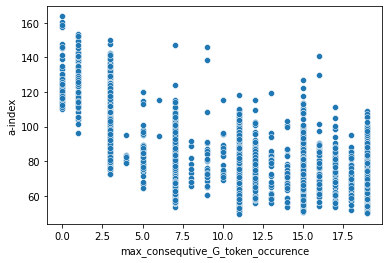

In [36]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_consequtive_G_token_occurence'] < 20])

Оценим соответствующую корреляцию

In [38]:
df.loc[df['max_consequtive_G_token_occurence'] < 20][['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,-0.662932,-0.664397
max_consequtive_token_occurence,-0.662932,1.000000,0.998754
max_consequtive_G_token_occurence,-0.664397,0.998754,1.000000


# Выводы

- частоты символа G отрицательно коррелированы с А-индексом;
- частоты подряд идущего символа G отрицательно коррелированы с А-индексом.

# Анализ связи А-индекса с некоторыми метриками кода

In [39]:
from radon.visitors import ComplexityVisitor
from radon.complexity import cc_rank
from radon.metrics import h_visit, mi_visit
from radon.raw import analyze
import numpy as np

Предварительная обработка сниппетов. Удаляем лишние пробелы.

In [40]:
import re

def checkExtraSpaces(snippet):
    number_of_spaces_to_remove = re.search('\S', snippet.split('\n')[0]).start(0)
    if number_of_spaces_to_remove > 0:
        return True

In [41]:
def removeExtraSpaces(snippet):
    number_of_spaces_to_remove = re.search('\S', snippet.split('\n')[0]).start(0)
    return '\n'.join([snippet_line[number_of_spaces_to_remove:] 
                      for snippet_line in snippet.split('\n')])

In [42]:
def refineSnippet(snippet):
    try:
        ComplexityVisitor.from_code(snippet)
        return snippet
    except:
        try:
            snippet_with_removed_extra_spaces = removeExtraSpaces(snippet)
            ComplexityVisitor.from_code(snippet_with_removed_extra_spaces)
            return snippet_with_removed_extra_spaces
        except:
            return np.nan

In [43]:
def compileSourceCode(snippet,
                      print_snippet=False):
    try:
        compile(snippet.strip(), 'file', 'exec')
        return True
    except SyntaxError as e:
        if ('no binding' not in e.msg) and ('unexpected indent' not in e.msg) and ('unindent' not in e.msg):
            print(e)
            if print_snippet:
                print(snippet)
            return False
        else:
            return True

Предобработка кода: удаление лишних пробелов и синтаксически некорректного кода.

In [44]:
df['before_merge_preprocessed'] = df['before_merge'].apply(removeExtraSpaces)
df['before_merge_preprocessed'] = df['before_merge_preprocessed'].apply(refineSnippet)
df['syntax_correct'] = df['before_merge'].apply(compileSourceCode)
df = df.loc[df['before_merge_preprocessed'].notna() & df['syntax_correct']]

EOF while scanning triple-quoted string literal (file, line 327)
EOF while scanning triple-quoted string literal (file, line 111)
EOF while scanning triple-quoted string literal (file, line 111)
EOF while scanning triple-quoted string literal (file, line 101)
invalid syntax (file, line 25)
invalid syntax (file, line 118)
invalid syntax (file, line 83)
EOF while scanning triple-quoted string literal (file, line 21)
EOF while scanning triple-quoted string literal (file, line 56)
invalid syntax (file, line 52)
invalid syntax (file, line 15)
EOF while scanning triple-quoted string literal (file, line 45)
invalid syntax (file, line 5)


Функции вычисления метрик

In [45]:
def computeCyclomaticComplexity(snippet):
    return ComplexityVisitor.from_code(snippet).functions_complexity

In [46]:
def computeHastadMetrics(snippet):
    hastad_metrics = h_visit(snippet).total
    return {metric:getattr(hastad_metrics, metric) for metric in dir(hastad_metrics) 
            if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}

In [47]:
def computeRawMetrics(snippet):
    try:
        raw_metrics = analyze(snippet)
        return {metric:getattr(raw_metrics, metric) for metric in dir(raw_metrics) 
                if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}
    except SyntaxError:
        return None

In [48]:
def computeMIindex(snippet):
    try:
        return mi_visit(snippet, multi=False)
    except SyntaxError:
        return np.nan

# Подсчет метрик

## Цикломатическая сложность

In [49]:
df['cc'] = df['before_merge_preprocessed'].apply(computeCyclomaticComplexity)

## Метрики Хастада

In [50]:
hastad_metrics = df['before_merge_preprocessed'].apply(computeHastadMetrics)

In [51]:
for col in hastad_metrics.loc[0].keys():
    df[col] = hastad_metrics.apply(lambda x: x[col])

## Сырые метрики

In [52]:
raw_metrics = df['before_merge_preprocessed'].apply(computeRawMetrics)

In [53]:
for col in raw_metrics.loc[0].keys():
    df[col] = raw_metrics.apply(lambda x: x[col] if x else np.nan)

## Индекс качества кода

In [54]:
df['MI'] = df['before_merge_preprocessed'].apply(computeMIindex)

# Связь с метриками

Формируем список всех метрик.

In [55]:
metric_names = ['cc', 'N1', 'N2', 'bugs', 'calculated_length', 'difficulty',
                'effort', 'h1', 'h2', 'length', 'time', 'vocabulary', 
                'volume', 'blank', 'comments', 'lloc', 'loc', 'multi',
                'single_comments', 'sloc', 'MI']

In [56]:
pd.set_option('display.max_columns', 500)

Подсчитаем корреляции

In [57]:
df[metric_names + ['a-index']].corr(method='spearman').round(2)

,cc,N1,N2,bugs,calculated_length,difficulty,effort,h1,h2,length,time,vocabulary,volume,blank,comments,lloc,loc,multi,single_comments,sloc,MI,a-index
cc,1.00,0.81,0.81,0.81,0.80,0.80,0.81,0.80,0.81,0.81,0.81,0.81,0.81,0.53,0.52,0.82,0.74,0.14,0.48,0.79,-0.72,-0.52
N1,0.81,1.00,1.00,1.00,0.98,0.97,0.99,0.97,0.99,1.00,0.99,0.99,1.00,0.55,0.51,0.78,0.72,0.16,0.47,0.75,-0.83,-0.41
N2,0.81,1.00,1.00,1.00,0.99,0.97,1.00,0.97,1.00,1.00,1.00,0.99,1.00,0.54,0.51,0.78,0.71,0.16,0.46,0.74,-0.83,-0.41
bugs,0.81,1.00,1.00,1.00,0.99,0.97,1.00,0.97,1.00,1.00,1.00,1.00,1.00,0.54,0.51,0.78,0.71,0.16,0.47,0.74,-0.83,-0.41
calculated_length,0.80,0.98,0.99,0.99,1.00,0.96,0.99,0.97,1.00,0.99,0.99,1.00,0.99,0.54,0.51,0.77,0.71,0.16,0.46,0.74,-0.82,-0.41
difficulty,0.80,0.97,0.97,0.97,0.96,1.00,0.99,0.99,0.96,0.97,0.99,0.97,0.97,0.54,0.50,0.76,0.69,0.17,0.46,0.72,-0.81,-0.42
effort,0.81,0.99,1.00,1.00,0.99,0.99,1.00,0.98,0.99,1.00,1.00,0.99,1.00,0.54,0.51,0.78,0.71,0.16,0.47,0.74,-0.83,-0.42
h1,0.80,0.97,0.97,0.97,0.97,0.99,0.98,1.00,0.97,0.97,0.98,0.98,0.97,0.54,0.50,0.76,0.70,0.17,0.46,0.72,-0.81,-0.43
h2,0.81,0.99,1.00,1.00,1.00,0.96,0.99,0.97,1.00,0.99,0.99,1.00,1.00,0.54,0.51,0.77,0.71,0.16,0.46,0.74,-0.83,-0.41
length,0.81,1.00,1.00,1.00,0.99,0.97,1.00,0.97,0.99,1.00,1.00,0.99,1.00,0.54,0.51,0.78,0.71,0.16,0.47,0.74,-0.83,-0.41


Вычислим медианные значения А-индекса при фиксированном значении метрик:

In [58]:
def groupedTargetMedian(data, 
                        feature_name, 
                        feature_value,
                        feature_std,
                        target_name):
    return data.loc[(data[feature_name] > feature_value - 0.1 * feature_std) &
                    (data[feature_name] < feature_value + 0.1 * feature_std), target_name].median(axis=0)

In [59]:
stds = df[metric_names].std(axis=0)

for metric_name in metric_names:
    df['a-index median given ' + metric_name + ' value'] = df[metric_name].apply(lambda x: 
                                                                                 groupedTargetMedian(df,
                                                                                                     metric_name,
                                                                                                     x,
                                                                                                     stds[metric_name],
                                                                                                     'a-index'))

Функция рисования графиков.

In [60]:
def plotScatterPlots(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.scatterplot(x=var_name, y='a-index', data=data)
            sb.scatterplot(x=var_name, y='a-index median given ' + var_name + ' value', data=data)
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

Показаны диаграммы рассеяния между А-индексом и метрикой, а также между медианой А-индекса и метрикой. Для более явной картины убрали выбросы.

In [61]:
df.loc[df['N1'] <= 100].shape[0] / df.shape[0] * 100

99.69933854479855

Показываются переменные 0 to 5 ...


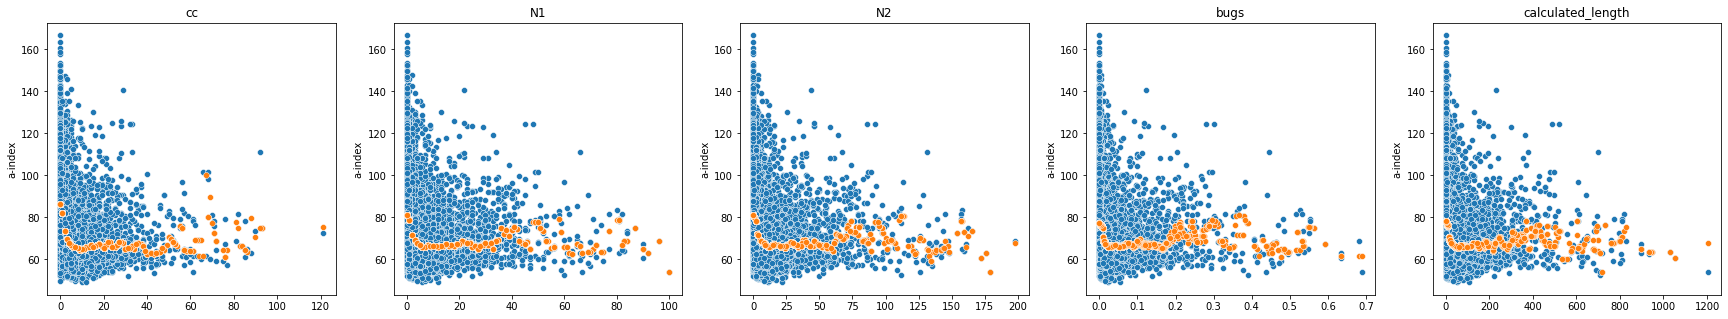

Показываются переменные 5 to 10 ...


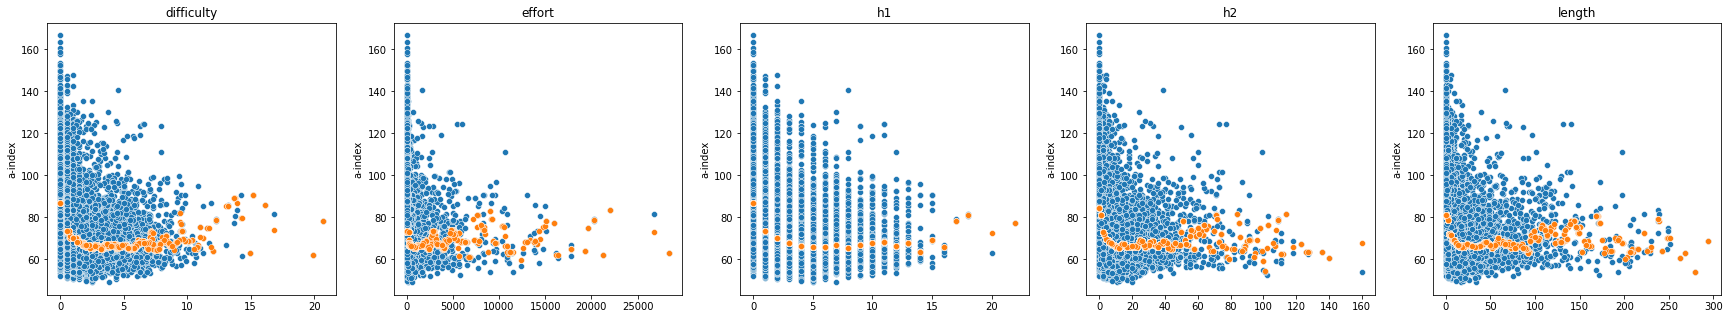

Показываются переменные 10 to 15 ...


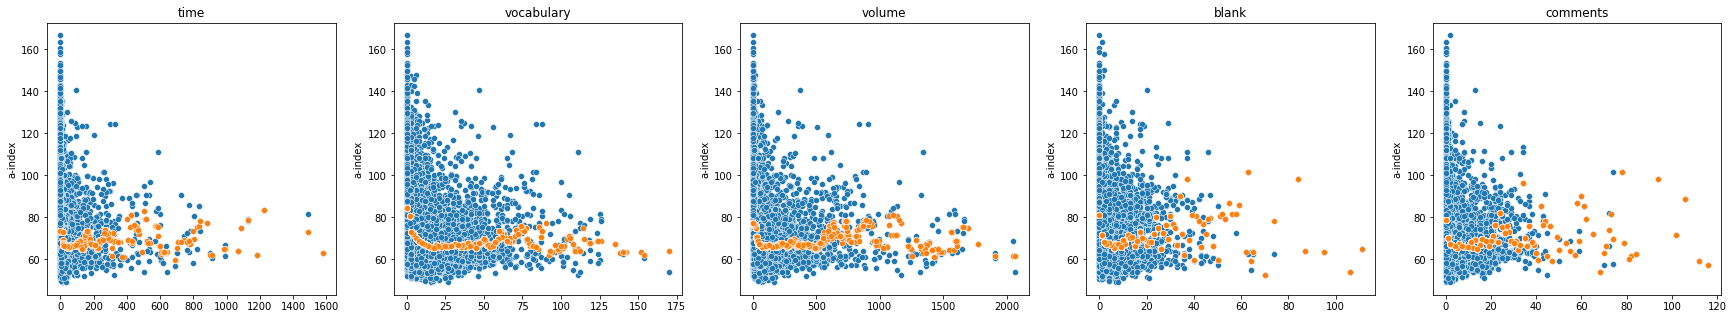

Показываются переменные 15 to 20 ...


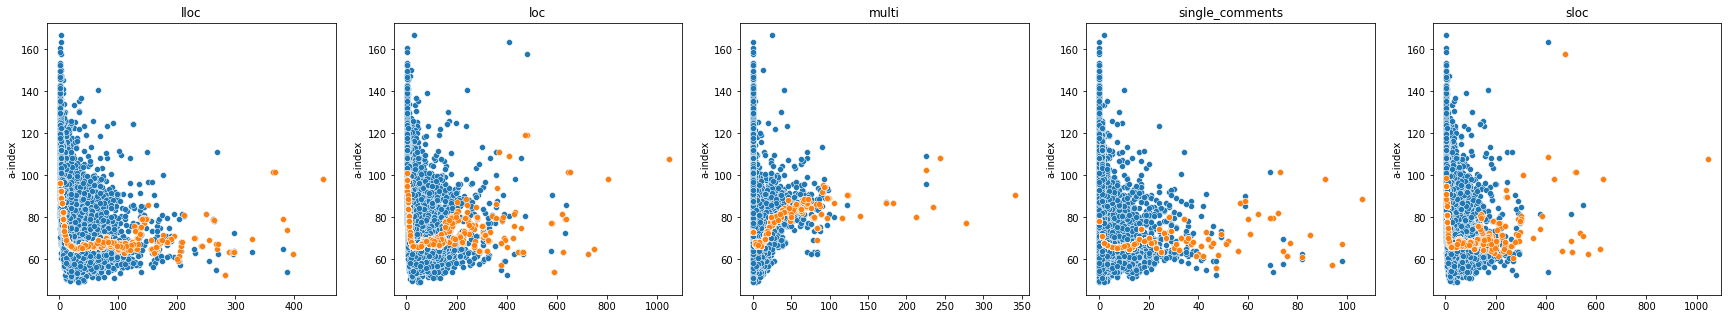

Показываются переменные 20 to 25 ...


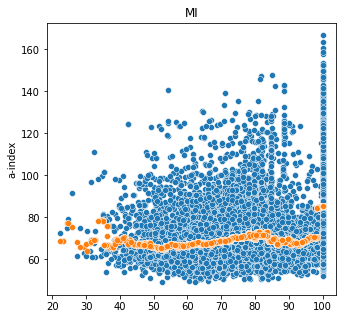

In [62]:
plotScatterPlots(df.loc[df['N1'] <= 100], metric_names)

In [63]:
def plotHistograms(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.histplot(x=var_name, data=data, bins=100,
                        stat='count')
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

Показываются переменные 0 to 5 ...


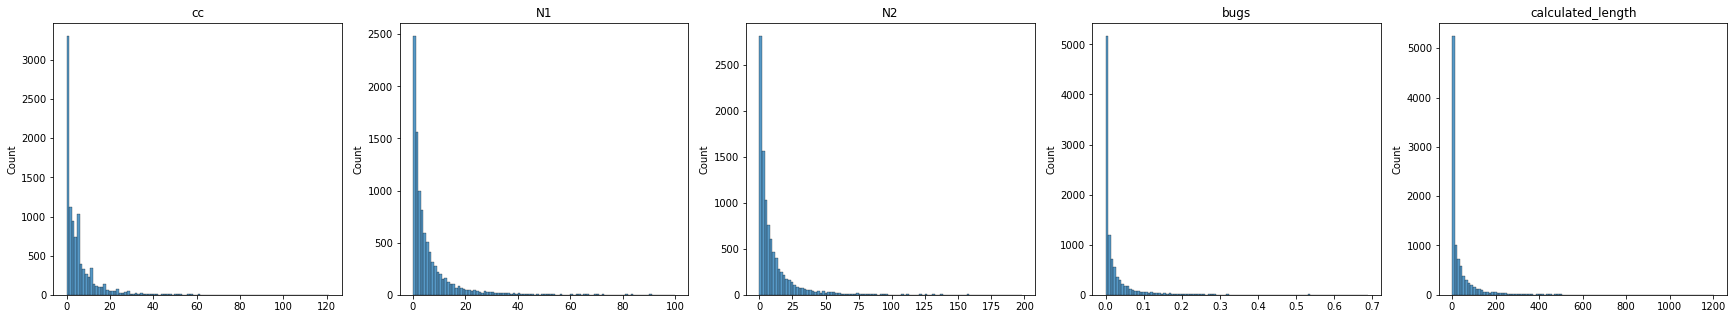

Показываются переменные 5 to 10 ...


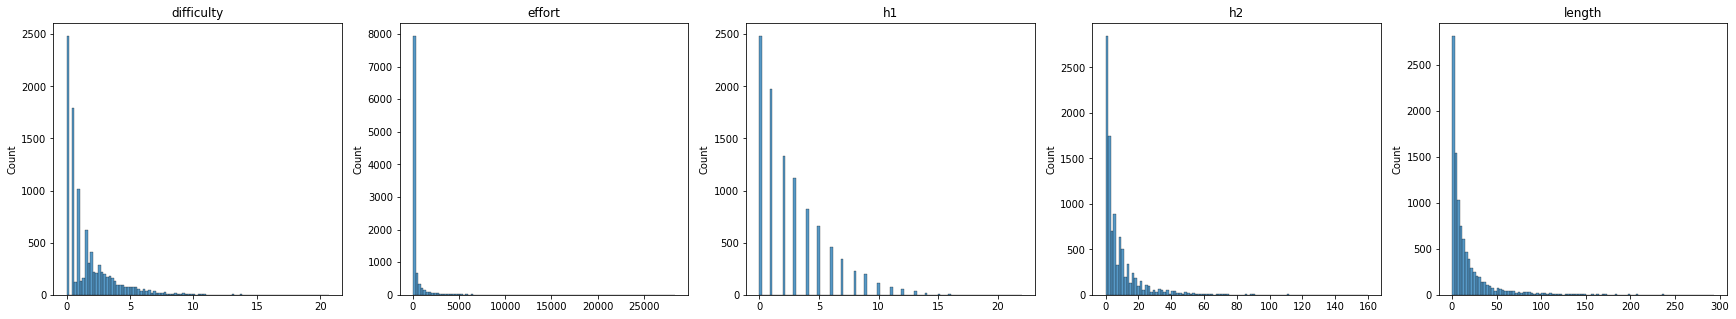

Показываются переменные 10 to 15 ...


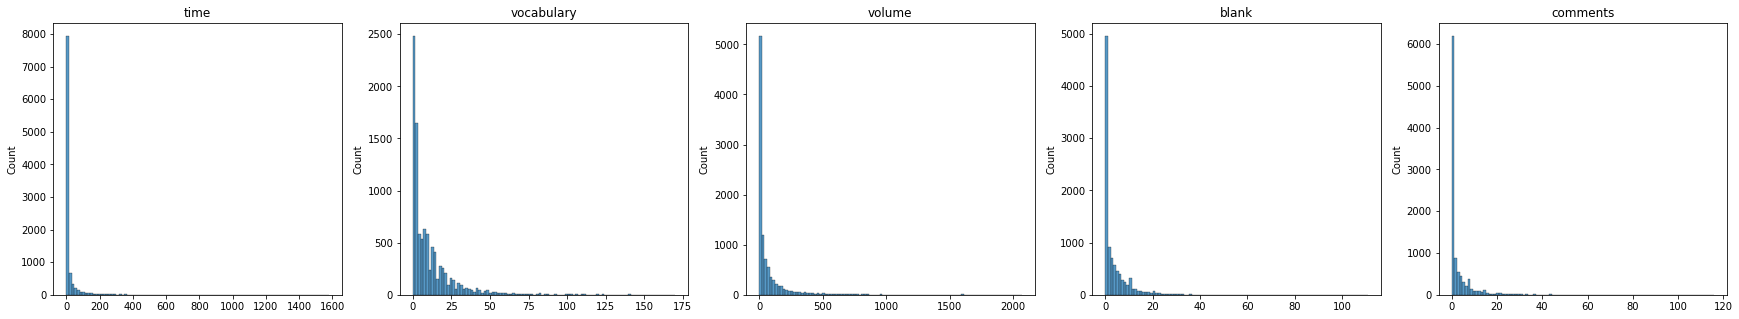

Показываются переменные 15 to 20 ...


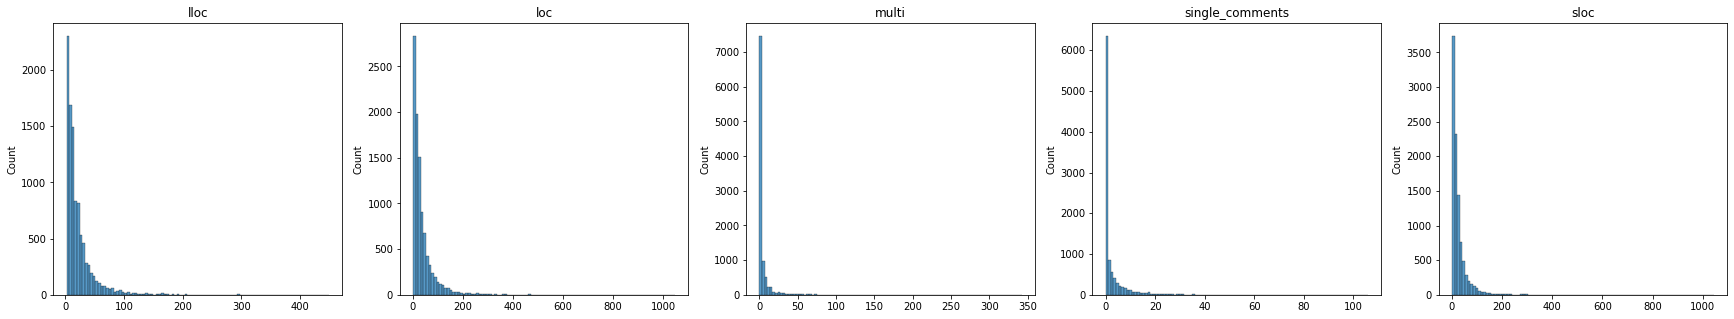

Показываются переменные 20 to 25 ...


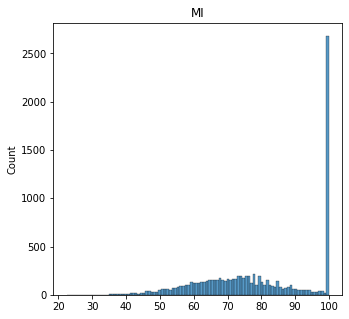

In [64]:
plotHistograms(df.loc[df['N1'] <= 100], metric_names);

# Выводы

- при росте значений метрик разброс аномальности быстро уменьшается за счет того что количество сниппетов с ростом значения метрик быстро убывает;
- для сниппетов малой длины и сложности разброс значений аномальности велик, среди них много аномальных сниппетов;

Посмотрим на связь метрик и аномальности для очень малых значений метрик, для которых достаточно много сниппетов.

Показываются переменные 0 to 5 ...


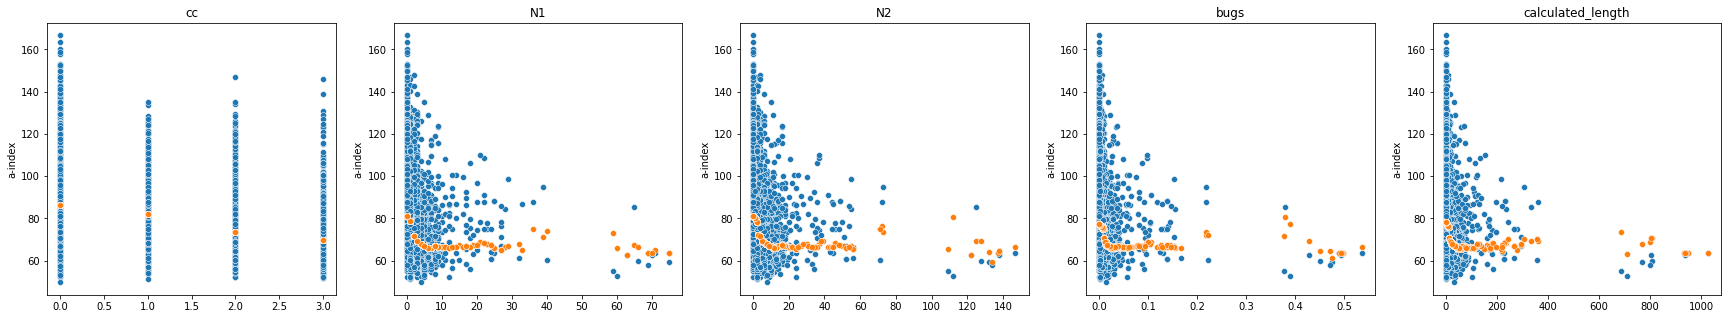

Показываются переменные 5 to 10 ...


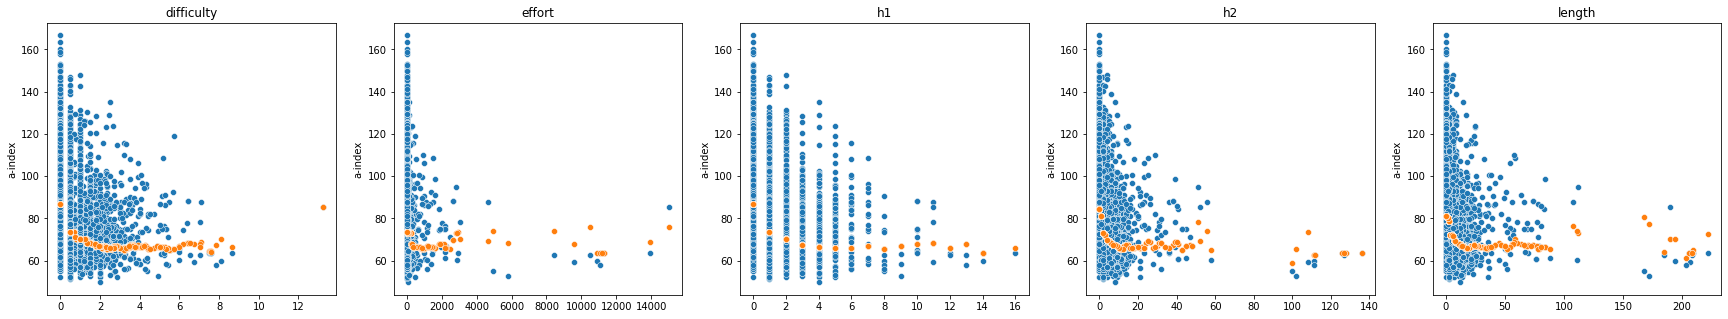

Показываются переменные 10 to 15 ...


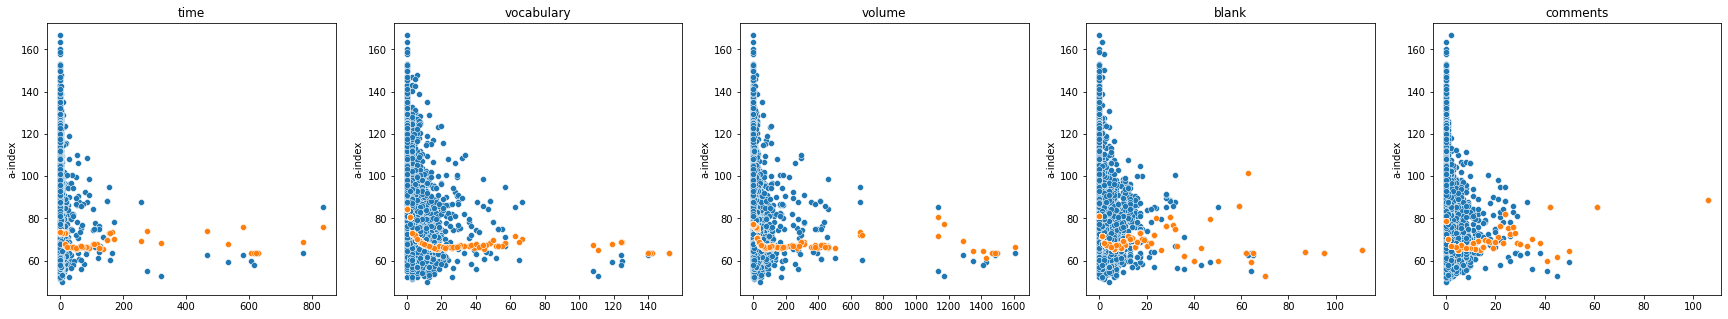

Показываются переменные 15 to 20 ...


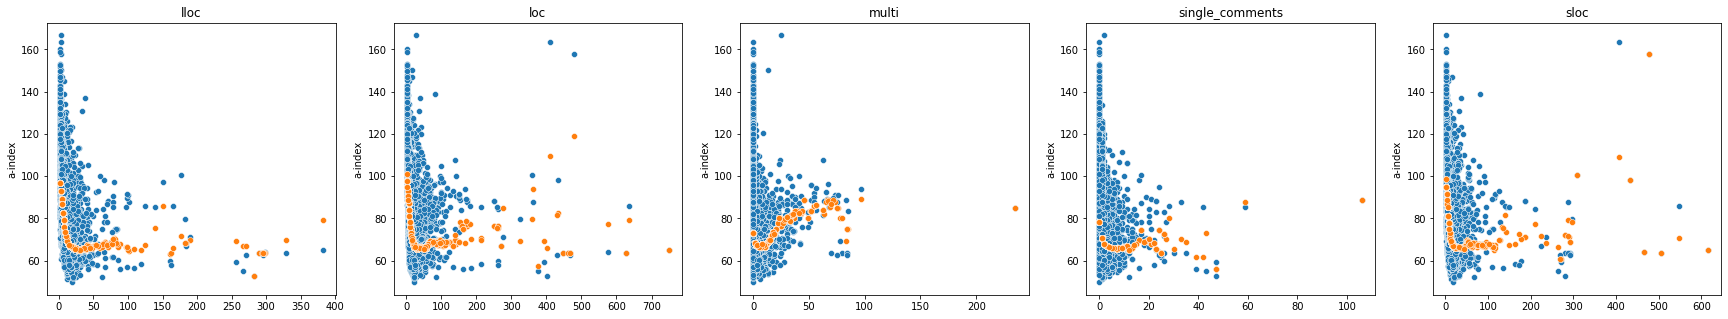

Показываются переменные 20 to 25 ...


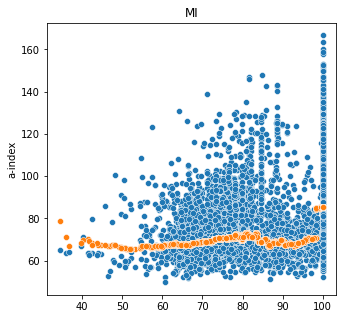

In [65]:
plotScatterPlots(df.loc[df['cc'] <= 3], metric_names)

# Выводы

Для малых значений метрик аномальность уменьшается с ростом сложности кода.

# Анализ распределения А-индекса

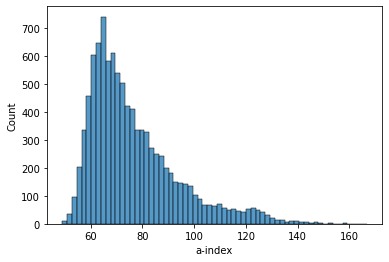

In [66]:
sb.histplot(x='a-index', data=df);

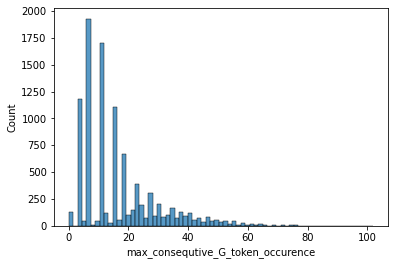

In [67]:
sb.histplot(x='max_consequtive_G_token_occurence', data=df);

# Анализ распределения А-индекса для короткого кода

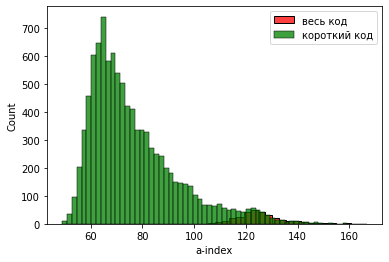

In [68]:
sb.histplot(x='a-index', data=df.loc[df['loc'] <=2], label='короткий код', color='r');
sb.histplot(x='a-index', data=df, label='весь код', color='g');
plt.legend();

Видно что короткий код имеет более высокий А-индекс.

In [8]:
pt.calc_anomalies(pt.get_python_paths('D:\\source\\git_projects\\zephyr\\anomaly\\sample_code\\'))

[('D:\\source\\git_projects\\zephyr\\anomaly\\sample_code\\dynamic_programming.py',
  0,
  py 0:25
  def longest_subsequence(array: list[int]) -> list[int]: 
      array_length = len(array)
      if array_length <= 1:
          return array
          # Else
      pivot = array[0]
      isFound = False
      i = 1
      longest_subseq = []
      while not isFound and i < array_length:
          if array[i] < pivot:
              isFound = True
              temp_array = [element for element in array[i:] if element >= array[i]]
              temp_array = longest_subsequence(temp_array)
              if len(temp_array) > len(longest_subseq):
                  longest_subseq = temp_array
          else:
              i += 1
  
      temp_array = [element for element in array[1:] if element >= pivot]
      temp_array = [pivot] + longest_subsequence(temp_array)
      if len(temp_array) > len(longest_subseq):
          return temp_array
      else:
          return longest_subseq,
  73.30092,